# 10장 시계열 데이터와 순환 신경망

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 10장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요내용

- 시계열 데이터 머신러닝 과제 예제
- 순환신경망(RNN, recurrent neural network) 이해
- 온도 예측 RNN 모델 구현
- 고급 RNN 활용 패턴

## 10.1 시계열 데이터 예제

**시계열**(timeseries)은 일정 간격으로 측정된 값들로 이루어진 데이터이다. 

- 일일 단위 증시 가격
- 도시의 시간당 소비 전력
- 매장의 주별 판매량

시계열은 자연현상 및 사람들의 일상에서 쉽게 구할 수 있다.

- 지진 활동
- 물고기 개체수
- 지역 날씨
- 웹사이트 방문자수
- 국내총생산(GDP)

시계열과 관련된 대표적인 과제는 **예측**(forcasting)이다. 
예를 들어, 몇 시간 후의 소비 전력, 몇 달 후의 영업 이익, 며칠 뒤의 날씨 등을 예측하는 일이다. 
이외에 시계열과 관련된 과제는 다음과 같다.

- 분류(classification): 웹사이트 방문자의 활동 이력을 보고 사람인지 여부 판단
- 이벤트 탐지(event detection): 오디오 스트림 감시 도중 "Ok Google", "Hey Alexa", "시리야" 등 핫워드(hotword) 탐지
- 이상치 탐지(anomaly detection): 생산라인 중에 발생하는 특이현상, 회사 네트워크 상에 발생하는 특이 활동 등 탐지.
    비지도 학습 활용.

## 10.2 예제: 온도 예측

나머지 이야기는 24시간 이후의 온도를 예측하는 모델을 구현하는 것이다. 
적절한 모델 구현과정을 통해 기존에 사용했던 밀집 연결 모델, 합성곱 모델 등은 적절하지 않고 
시계열 데이터에 대한 새로운 접근방식을 사용하는 **순환 신경망**(recurrent neural network, RNN)이
훨씬 잘 작동함을 보게 될 것이다. 

### 데이터셋 준비

독일 예나(Jena)시에 위치한 막스-플랑크(Max-Planck) 생지화확(Biogeochemistry) 연구소가
수 년동안 온도, 기압, 풍향 등 14 종류의 기상 데이터를 10분 단위로 측정해서 수집한 데이터셋이다. 
원래 2003년부터 측정하였지만 여기서는 2009-2016년 데이터만 이용한다. 

**zip 파일 다운로드 및 압축풀기**

"jena_climate_2009_2016.csv" 파일이 생성된다.

In [1]:
if 'google.colab' in str(get_ipython()):
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip
else: 
    try: 
        import wget, zipfile
    except ModuleNotFoundError: 
        !pip install wget
        import wget, zipfile
        wget.download('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip')
        with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
            zip_ref.extractall('./')

**예나(Jena) 날씨 데이터셋 살펴보기**

파일을 열어 줄(line) 단위로 쪼갠다.

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")

첫째 줄은 날짜와 시간 이외에 14개의 특성명이 쉼표(콤마)로 구분되어 있으며,
총 420,451개의 데이터를 포함한다.

In [3]:
header = lines[0].split(",")
lines = lines[1:]

In [4]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [5]:
print(len(lines))

420451


첫째 데이터는 2009년 1월 1일 0시 10분에 측정되었다.

In [6]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [7]:
lines[0].split(',')

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

2번 인덱스 항목이 섭씨 온도이다. 

In [8]:
lines[0].split(',')[2]

'-8.02'

**넘파이 어레이로 변환**

In [9]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]

    temperature[i] = values[1]    # i 번째 온도
    raw_data[i, :] = values[:]    # i 번째 데이터

**온도 변화 그래프**

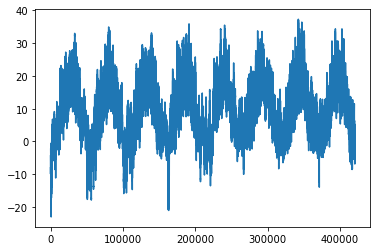

In [10]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

**처음 10일동안의 온도 변화**

한 시간에 6번, 하루 24시간, 10일동안 측정 횟수는 `6 * 24 * 10 = 1,440`이다.

- 1월 1일 - 1월 10일 기간동안 측정된 온도라 상당히 낮다.
- 마지막 4일 동안은 일 단위 온도 변화가 주기성을 띈다. 

**주기성**(periodicity)은 시계열 데이터의 기본 특성 중 하나이다.
월별 주기성은 매우 일관성을 갖는다. 
지난 몇 달동안의 데이터를 이용하여 다음 달의 평균 온도를 예측하는 일은 상대적으로 쉽다.
반면에 일 단위의 예측은 아래 그래프에서 보듯이 훨씬 혼잡하다. 

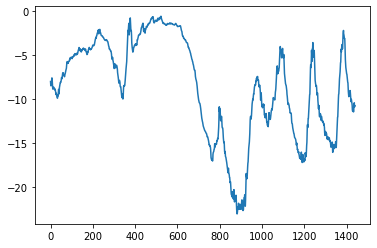

In [11]:
plt.plot(range(1440), temperature[:1440])

**훈련셋, 검증셋, 테스트셋 크기**

- 훈련셋: 전체의 50%
- 검증셋: 전체의 25%
- 테스트셋: 전체의 25%

미래에 대한 예측을 실행하므로 훈련셋, 검증셋, 테스트셋 순으로 
보다 오래된 데이터를 사용한다. 

In [12]:
num_train_samples = int(0.5 * len(raw_data))     # 전체의 50%
num_val_samples   = int(0.25 * len(raw_data))    # 전체의 25%
num_test_samples  = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:\t", num_train_samples)
print("num_val_samples:\t", num_val_samples)
print("num_test_samples:\t", num_test_samples)

num_train_samples:	 210225
num_val_samples:	 105112
num_test_samples:	 105114


### 데이터 전처리

시계열 데이터를 전처리 하려면 해결해야 할 문제를 명확히 지정해야 한다.
여기서는 지난 5일치의 날씨 데이터를 이용하여 앞으로 24시간 후의 온도를 예측하는 모델을 구현하고자 한다.
따라서 이 목적을 위한 시계열 데이터의 입력 샘플은 지난 5일치의 날씨 데이터를 하나의 시퀀스로 묶은 데이터이고,
타깃은 해당 시퀀스보다 24시간 앞선 데이터의 온도이어야 한다. 

5일 단위의 시퀀스와 타깃을 정하기 전에 먼저 기존 데이터셋을 정규화 한다.
즉, 특성별로 평균은 0, 표준편차는 1로 변환한다.

**주의사항**: 훈련셋의 평균값과 표준편차를 이용하여 모든 데이터셋을 정규화해야 한다.
앞서 언급한 것처럼 시계열 데이터의 훈련셋은 이른 시점에서의 데이터를 활용한다.

**데이터 정규화**

In [13]:
# 훈련셋의 평균
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

# 훈련셋의 표준편차
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**5일 단위 시퀀스 데이터 준비**

앞서 언급한 문제의 해결을 위한 모델을 구현하려면
5일 단위 시퀀스 데이터를 준비해야 하지만
`timeseries_dataset_from_array()` 함수를 활용하면 아주 쉽게 해결된다.
함수에 사용된 인자의 역할은 다음과 같다.

- `data`: 선택 대상 데이터셋 전체
- `targets`: 선택 대상 데이터셋 전체
- `sampling_rate`: 표본 비율. 몇 개 중에 하나를 선택할 것인지 지정.
- `sequence_length`: 시퀀스 샘플 길이
- `shuffle=True`: 생성된 시퀀스들의 순서를 무작위하게 섞음.
- `batch_size`: 배치 크기. 생성된 시퀀스들을 배치로 묶음.
- `start_index`: 표본 추출 대상 시작 구간
- `end_index`: 표본 추출 대상 끝 구간

In [14]:
from tensorflow import keras

# 1시간에 하나의 데이터 선택
sampling_rate = 6

# 입력 데이터 시퀀스: 지난 5일치(120시간) 온도 데이터
sequence_length = 120

# 타깃 설정:24시간 이후의 온도. 지연(delay)을 6일치로 지정
delay = sampling_rate * (sequence_length + 24 - 1)

# 배치 크기
batch_size = 256

# 훈련셋
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # 생성된 시퀀스들의 순서 무작위화
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# 검증셋
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# 테스트셋
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

생성된 새로운 데이터셋은 훈련셋의 샘플과 타깃을 함께 배치 단위로 묶여있다.
예를 들어, 훈련셋의 첫째 배치의 모양은 다음과 같다.

- 배치 크기: 256
- 시퀀스 샘플 모양: `(120, 14)`
    - 14개의 특성을 갖는 날씨 데이터 5일치

In [15]:
for samples, targets in train_dataset:
    print("샘플 모양:", samples.shape)
    print("타깃 모양:", targets.shape)
    break

샘플 모양: (256, 120, 14)
타깃 모양: (256,)


**참고: `timeseries_dataset_from_array()` 활용법**

아래 코드는 넘파이 어레이를 이용하여 
`timeseries_dataset_from_array()` 함수의 작동법을 설명한다.

In [16]:
int_sequence = np.arange(10)
int_sequence

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

길이가 3인 시퀀스 샘플을 2개씩 묶은 배치 3개가 만들어진다. 

In [18]:
i = 0
for inputs, targets in dummy_dataset:
    print(f"배치 {i}:")
    print("  samples shape:", inputs.shape)
    print("  targets shape:", targets.shape)
    print()
    i += 1

배치 0:
  samples shape: (2, 3)
  targets shape: (2,)

배치 1:
  samples shape: (2, 3)
  targets shape: (2,)

배치 2:
  samples shape: (1, 3)
  targets shape: (1,)



배치 별 샘플과 타깃을 확인하면 다음과 같다.

In [19]:
i = 0
for inputs, targets in dummy_dataset:
    print(f"배치 {i}:")
    for i in range(inputs.shape[0]):
        print("  샘플:", [int(x) for x in inputs[i]], "  타깃:", int(targets[i]))
    
    print()
    i += 1

배치 0:
  샘플: [0, 1, 2]   타깃: 3
  샘플: [1, 2, 3]   타깃: 4

배치 2:
  샘플: [2, 3, 4]   타깃: 5
  샘플: [3, 4, 5]   타깃: 6

배치 2:
  샘플: [4, 5, 6]   타깃: 7



### 베이스라인 설정

모델 성능의 최저 기준선으로 24시간 후의 온도를 현재 온도로 예측하는 것을 사용한다.
즉, 내일 이 시간 온도가 현재 온도와 별 차이가 없다는 가정을 이용한다. 
그러면 검증셋과 테스트셋에 대한 평균절대오차는 각각 2.44와 2.62이다.

In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  # 원 데이터로 되돌리기
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증셋 평균절대오차(MAE): {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트셋 평균절대오차(MAE): {evaluate_naive_method(test_dataset):.2f}")

검증셋 평균절대오차(MAE): 2.44
테스트셋 평균절대오차(MAE): 2.62


### 밀집 연결 모델 성능

밀집층만을 사용하는 모델의 성능은 베이스라인과 비슷하게 나온다.

- 평균절대오차는 모델평가지표로 사용한다.
- 손실함수는 (미분가능한 함수인) 평균제곱근오차를 사용한다.

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# 최선 모델 활용
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 9ms/step - loss: 13.2325 - mae: 2.8003 - val_loss: 13.1980 - val_mae: 2.8906
Epoch 2/10
819/819 [==============================] - 8s 9ms/step - loss: 9.0143 - mae: 2.3629 - val_loss: 10.0184 - val_mae: 2.4945
Epoch 3/10
819/819 [==============================] - 8s 9ms/step - loss: 8.3270 - mae: 2.2739 - val_loss: 10.2828 - val_mae: 2.5282
Epoch 4/10
819/819 [==============================] - 8s 9ms/step - loss: 7.8874 - mae: 2.2105 - val_loss: 10.0891 - val_mae: 2.4995
Epoch 5/10
819/819 [==============================] - 8s 9ms/step - loss: 7.6047 - mae: 2.1687 - val_loss: 10.2898 - val_mae: 2.5245
Epoch 6/10
819/819 [==============================] - 8s 9ms/step - loss: 7.3592 - mae: 2.1323 - val_loss: 12.6840 - val_mae: 2.8234
Epoch 7/10
819/819 [==============================] - 8s 9ms/step - loss: 7.1615 - mae: 2.1057 - val_loss: 11.0099 - val_mae: 2.6124
Epoch 8/10
819/819 [==============================] - 8s 9ms/step - 

학습과정을 그래프로 나타내면 다음과 같다.

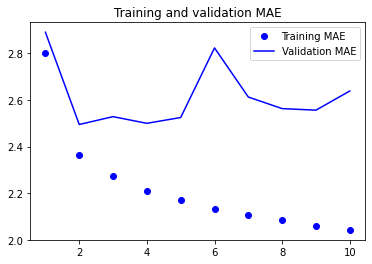

In [22]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 신경망 모델 성능

`Conv1D` 층은 `Conv2D` 층에서 사용된 필터 개념을 1차원 텐서에 대해 동일한
방식으로 적용한다. 
`MaxPooling1D` 층 또한 `MaxPooling2D`와 동일한 방식으로 작동한다.

아래 모델은 `Conv1D`와 `MaxPooling1D` 층을 이용한 합성곱 신경망 모델을
온도 예측에 활용한 결과를 보여준다.
그런데 매우 실망스럽다.

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# 최선 모델 활용
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 12ms/step - loss: 21.9152 - mae: 3.6608 - val_loss: 15.4688 - val_mae: 3.1435
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 15.5923 - mae: 3.1428 - val_loss: 14.9357 - val_mae: 3.0605
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 14.4798 - mae: 3.0245 - val_loss: 15.8115 - val_mae: 3.1287
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 13.5093 - mae: 2.9177 - val_loss: 14.3347 - val_mae: 2.9919
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 12.7750 - mae: 2.8350 - val_loss: 14.8836 - val_mae: 3.0492
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 12.2123 - mae: 2.7711 - val_loss: 15.0305 - val_mae: 3.0534
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 11.7144 - mae: 2.7141 - val_loss: 18.6135 - val_mae: 3.4234
Epoch 8/10
819/819 [==============================] - 

학습과정을 그래프로 나타내면 다음과 같으며, 밀집 연결 모델보다 훨씬 성능이 나쁘다.

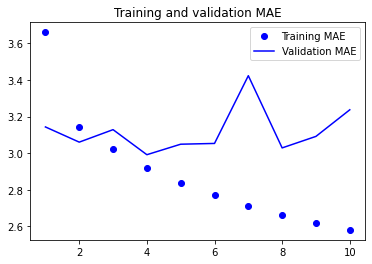

In [24]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 간단한 순환 모델 성능

가장 간단한 순환 신경망 모델이더라도 베이스라인보다 좋은 성능을 보여준다는 것을 확인할 수 있다.

- LSTM 층: 장단기 메모리(Long Short Term Memory) 층

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 17ms/step - loss: 44.3710 - mae: 4.8409 - val_loss: 12.6833 - val_mae: 2.6962
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 11.0339 - mae: 2.5777 - val_loss: 9.5880 - val_mae: 2.4041
Epoch 3/10
819/819 [==============================] - 14s 16ms/step - loss: 9.9279 - mae: 2.4534 - val_loss: 9.3511 - val_mae: 2.3813
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.6156 - mae: 2.4109 - val_loss: 9.2712 - val_mae: 2.3658
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 9.3630 - mae: 2.3764 - val_loss: 9.5573 - val_mae: 2.3953
Epoch 6/10
819/819 [==============================] - 14s 16ms/step - loss: 9.1418 - mae: 2.3501 - val_loss: 10.8980 - val_mae: 2.4927
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 8.9109 - mae: 2.3212 - val_loss: 9.5703 - val_mae: 2.3992
Epoch 8/10
819/819 [==============================] - 14s 

## 10.3 순환 신경망 이해

**순환 신경망(recurrent neural network)**

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-06.png" style="width:25%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### `SimpleRNN` 층

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_10-7.png" style="width:100%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### `LSTM` 층

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-10.png" style="width:100%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**NumPy implementation of a simple RNN**

In [26]:
timesteps = 100

input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

In [27]:
final_output_sequence.shape

(100, 64)

### A recurrent layer in Keras

**A RNN layer that can process sequences of any length**

In [28]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**A RNN layer that returns only its last output step**

In [29]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**A RNN layer that returns its full output sequence**

In [30]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [31]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### *_Going even further_*

## Chapter summary